# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
assert df.shape == (1460, 80)

In [4]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределени или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регресси через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выьросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

6.509812011089439

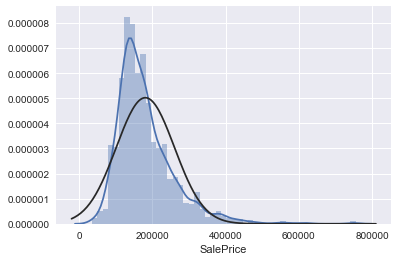

In [5]:
import scipy
sns.distplot(df["SalePrice"], fit=scipy.stats.norm)
scipy.stats.kurtosis(df["SalePrice"])

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.164745194154, 180921.19589041095, 0.93196656415129886))

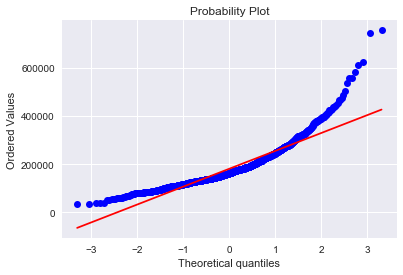

In [6]:
scipy.stats.probplot(df["SalePrice"], plot=plt)

распределение большаей части данных в выборке приближено к теоретическому, в верхней части графика видно сильное отклонение

## 1.2 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

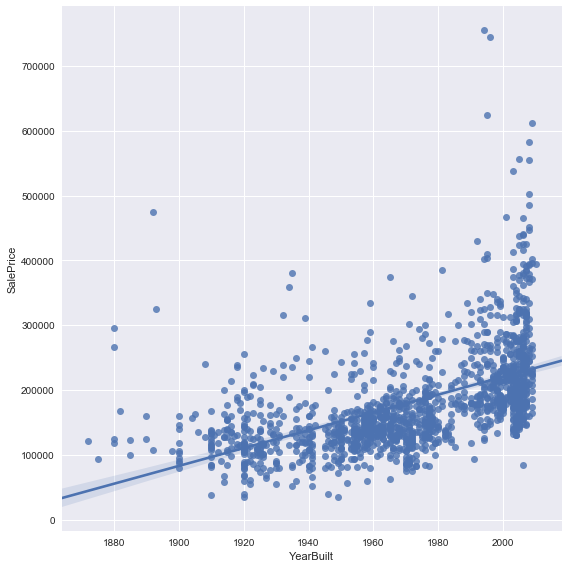

In [7]:
sns.lmplot('YearBuilt', 'SalePrice', data=df, size=8)

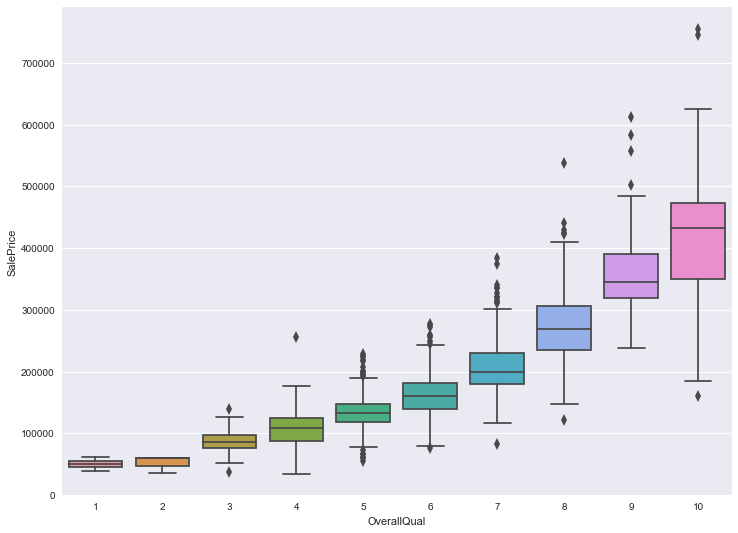

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)    
sns.boxplot(df['OverallQual'], df['SalePrice'], fliersize=8)


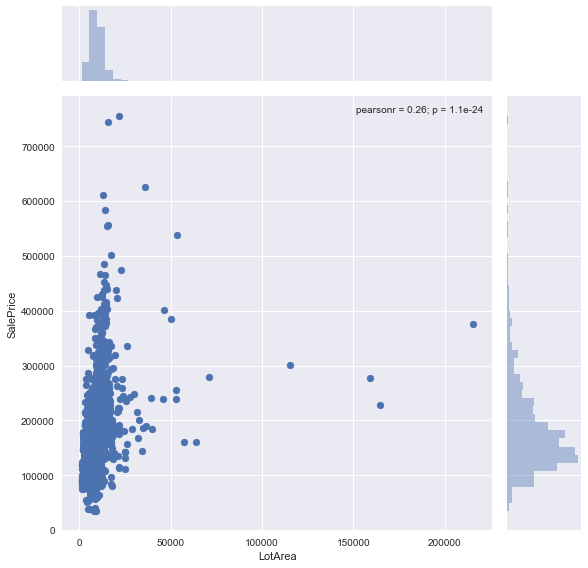

In [9]:
sns.jointplot(df['LotArea'], df['SalePrice'], size=8)

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

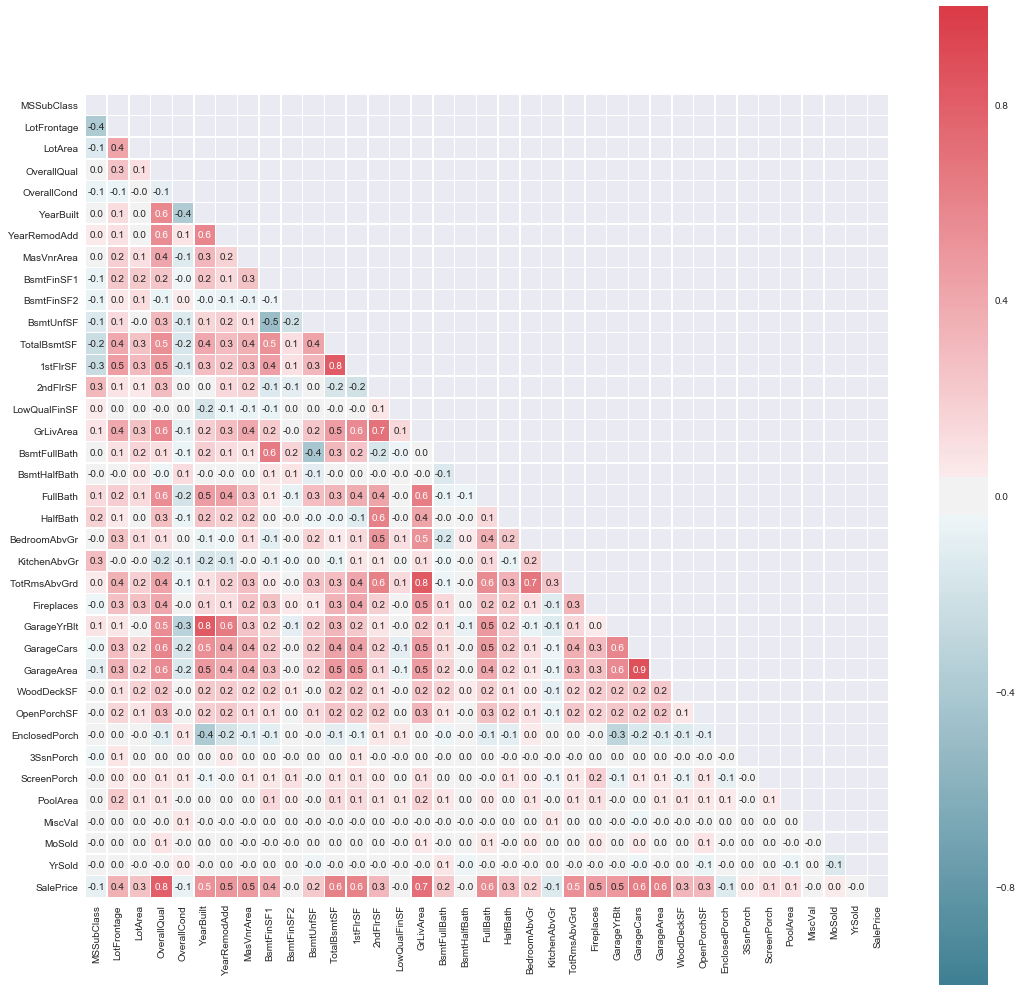

In [10]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,cmap=cmap, square=True,linewidths=.5, mask=mask,annot=True, fmt=".1f")

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

In [11]:
corr.shape

(37, 37)

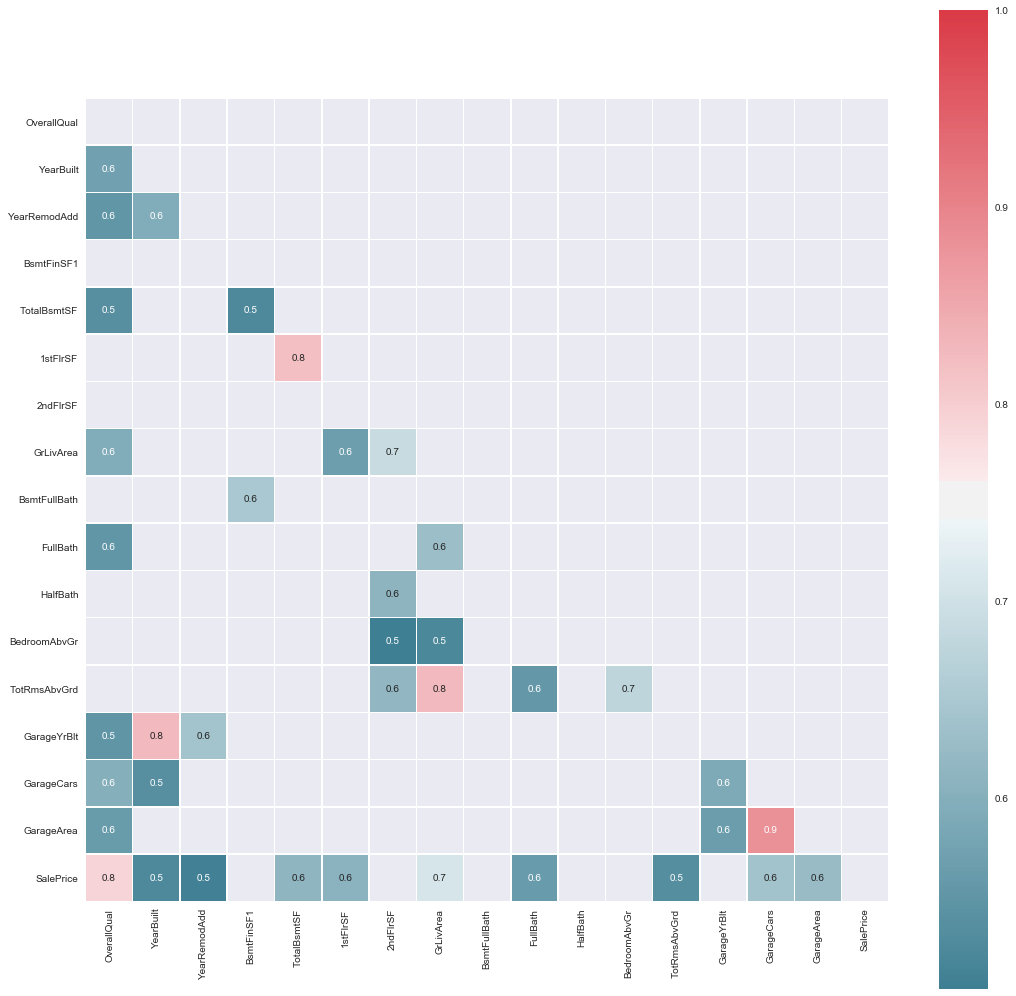

In [12]:
corr = df.corr()[np.abs(df.corr()) > 0.5]
corr = corr[corr.isnull().sum() !=36]
corr.dropna(axis=1, how='all', inplace=True)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,cmap=cmap, square=True,linewidths=.5, mask=mask,annot=True, fmt=".1f")

corr_features = corr[~ corr.isnull()].SalePrice
important_features = corr_features[~ corr_features.isnull()].index.drop('SalePrice')

## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hinst: https://stackoverflow.com/a/38134049/3205200

In [13]:
number_of_na = df.isnull().sum()
number_of_na

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [14]:
proportion_of_na = number_of_na / df.shape[0]
proportion_of_na[proportion_of_na > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [15]:
df = df.drop(proportion_of_na[proportion_of_na > 0.1].index, axis=1)

In [16]:
objects_data = df[(df.dtypes==object)[(df.dtypes==object) == True].index]
objects_data = objects_data.fillna('unknown')

numerical_data = df[(df.dtypes!=object)[(df.dtypes!=object) == True].index]
numerical_data = numerical_data.fillna(value=numerical_data.mean())
    
df = pd.concat([objects_data, numerical_data], axis=1)

## 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [17]:
df = pd.get_dummies(df)
df.shape

(1460, 281)

In [18]:
X = df.drop('SalePrice', axis=1)
Y = df['SalePrice']

## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
coefs = zip(X.columns, lr.coef_)
coefs = sorted(coefs, key=lambda coef: abs(coef[1]), reverse=True)
for column, coef in coefs:
    print('%s : %d' % (column, coef))

RoofMatl_ClyTile : -608103
Condition2_PosN : -193413
RoofMatl_Membran : 153235
RoofMatl_Metal : 124935
RoofMatl_WdShngl : 111029
GarageQual_Ex : 95320
GarageCond_Ex : -87958
Condition2_PosA : 83342
Condition2_RRAe : -83080
RoofStyle_Shed : 74872
RoofMatl_Tar&Grv : 63836
RoofMatl_CompShg : 58413
BsmtCond_Po : 50567
RoofMatl_WdShake : 49880
RoofMatl_Roll : 46772
Condition2_RRNn : 45505
Condition2_Artery : 44097
Functional_Sev : -42757
Electrical_Mix : -41058
Neighborhood_StoneBr : 40675
Condition2_Feedr : 39995
GarageQual_Po : -38810
Condition2_Norm : 37507
Exterior1st_ImStucc : -37000
LandSlope_Sev : -31176
Neighborhood_NoRidge : 29238
Condition2_RRAn : 26046
GarageQual_Fa : -24564
Foundation_Wood : -24033
GarageCond_Po : 23829
RoofStyle_Flat : -22700
Electrical_unknown : 22662
MSZoning_C (all) : -21958
Exterior2nd_ImStucc : 21950
GarageCond_TA : 21907
Exterior2nd_Other : -21464
HouseStyle_2.5Fin : -21411
Neighborhood_NridgHt : 20914
Functional_Typ : 20780
BsmtCond_Gd : -20606
Condition

In [21]:
from sklearn import model_selection
model_selection.cross_val_score(lr, X =X, y=Y, scoring='neg_mean_squared_error', cv=5).mean()

-1233301257.106895

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [22]:
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 10)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in alphas:
    lasso = Lasso(alpha = alpha, random_state=42)
    lasso.fit(X, Y)
    coefs_lasso[i, :] = lasso.coef_
    
    ridge = Ridge(alpha = alpha, random_state=42)
    ridge.fit(X, Y)
    coefs_ridge[i, :] = ridge.coef_
    
    i += 1

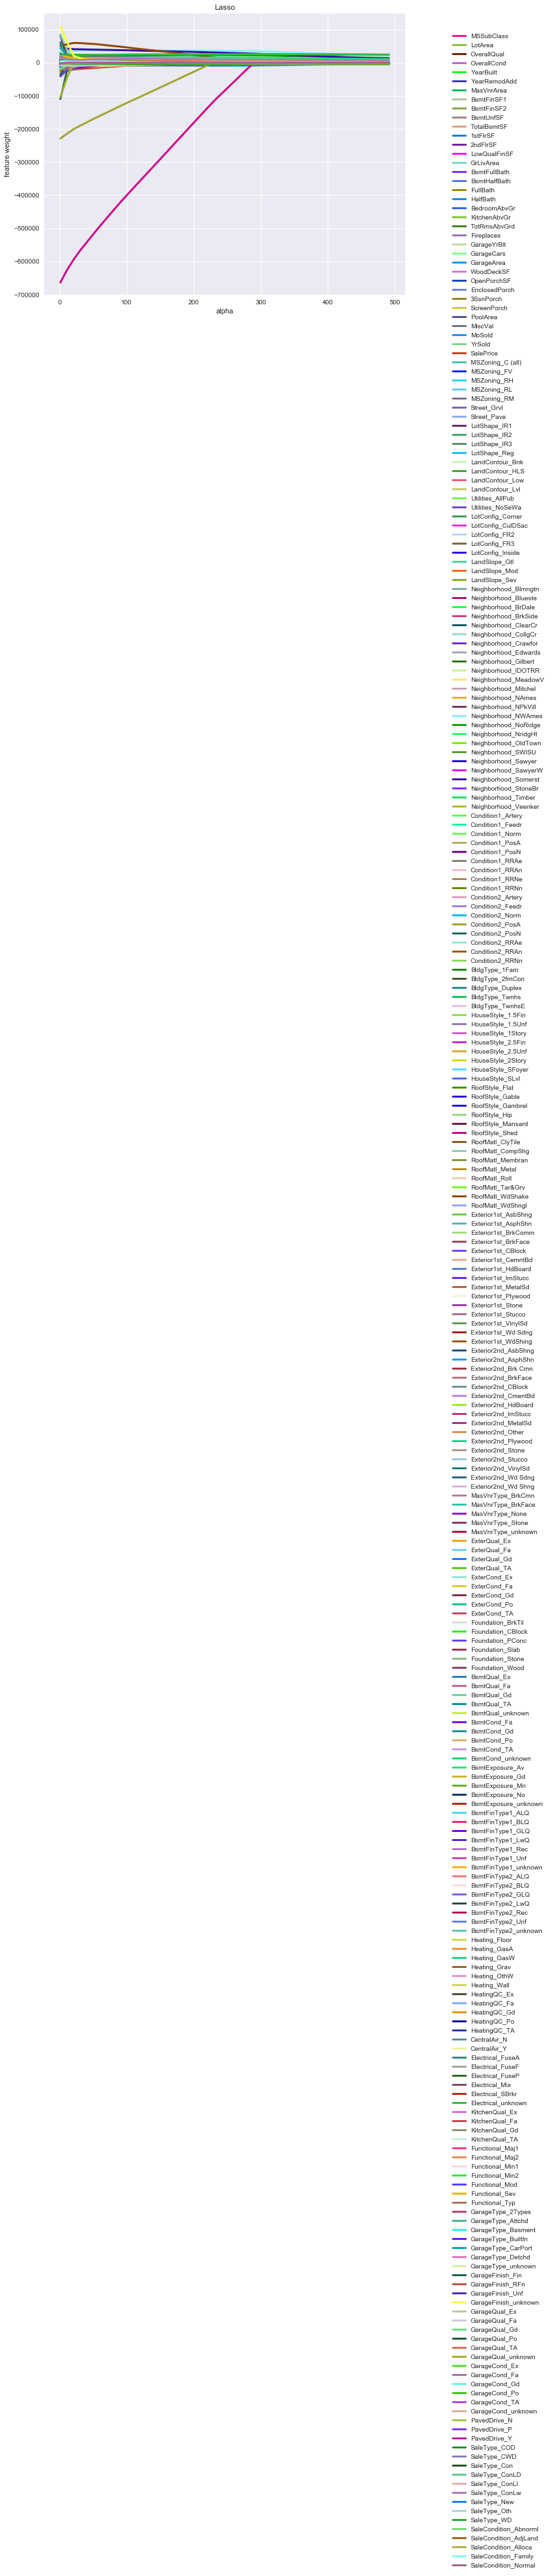

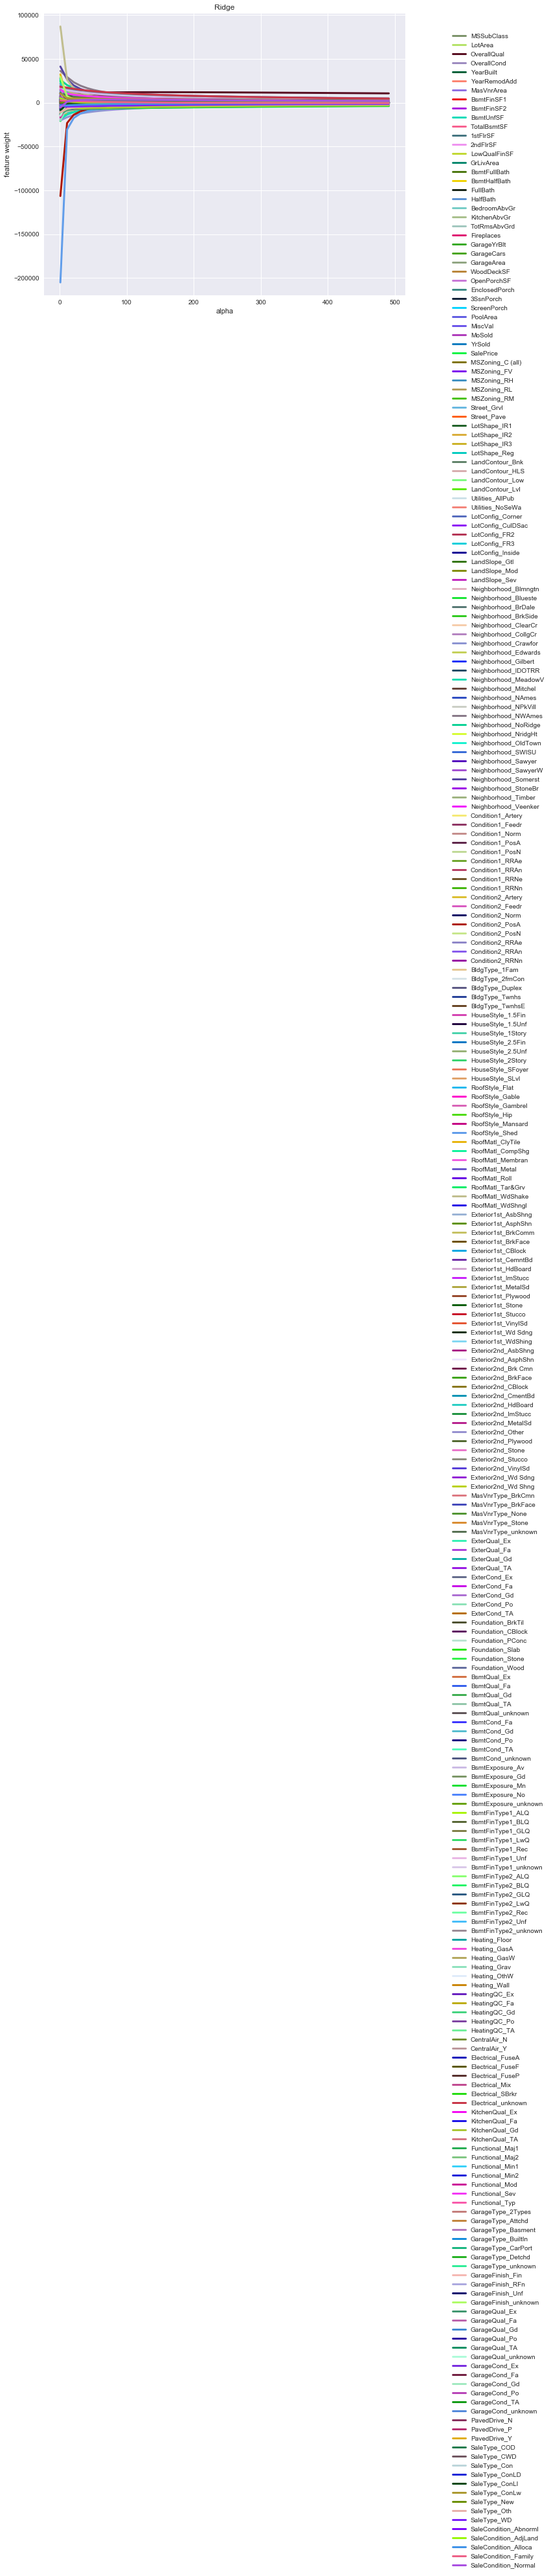

In [23]:
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

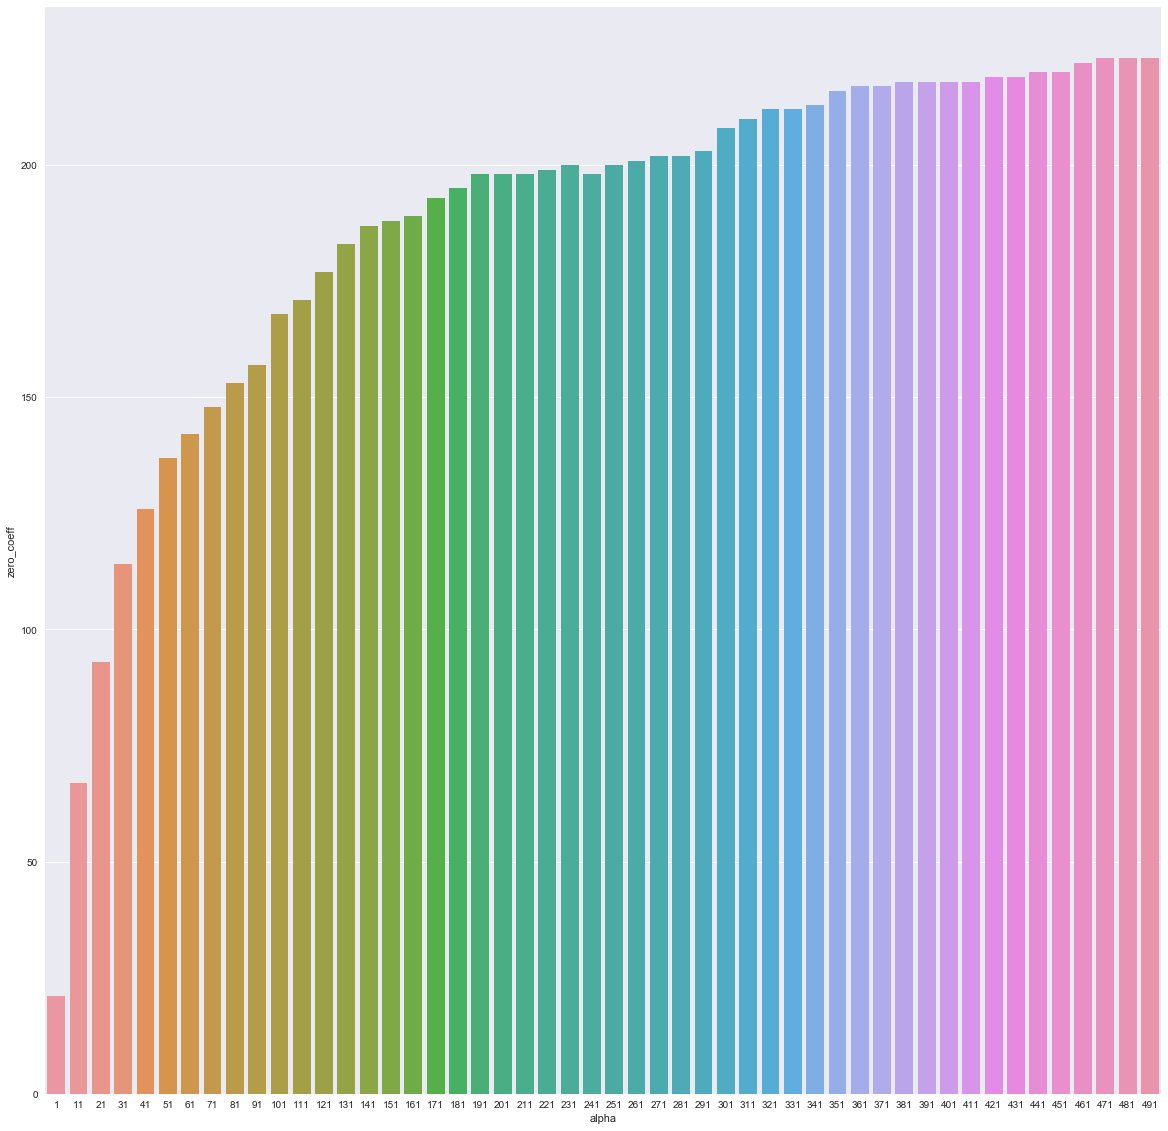

In [24]:
zero_coeff = [(np.abs(x) < 0.0001).sum() for x in coefs_lasso]
hist_data = pd.DataFrame(data = {'alpha': alphas, 'zero_coeff': zero_coeff})
plt.figure(figsize=(20, 20))
ax=sns.barplot(x='alpha', y='zero_coeff', data=hist_data) 
ax.set(xlabel='alpha', ylabel='zero_coeff')
plt.show()

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

In [25]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(n_jobs=3, alphas=alphas, random_state=42, cv=5)
lassocv.fit(X, Y)
alpha = lassocv.alpha_
alpha

141

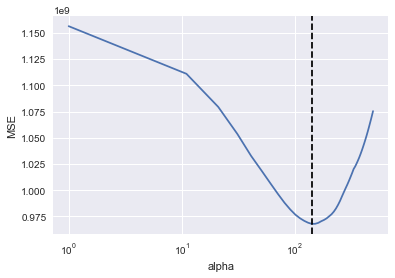

In [26]:
mean_mse = np.mean(lassocv.mse_path_, axis=1)

plt.plot(lassocv.alphas_, mean_mse)

plt.ylabel('MSE')
plt.xlabel('alpha')
plt.axvline(alpha, color='black', ls='--')
plt.xscale('log')

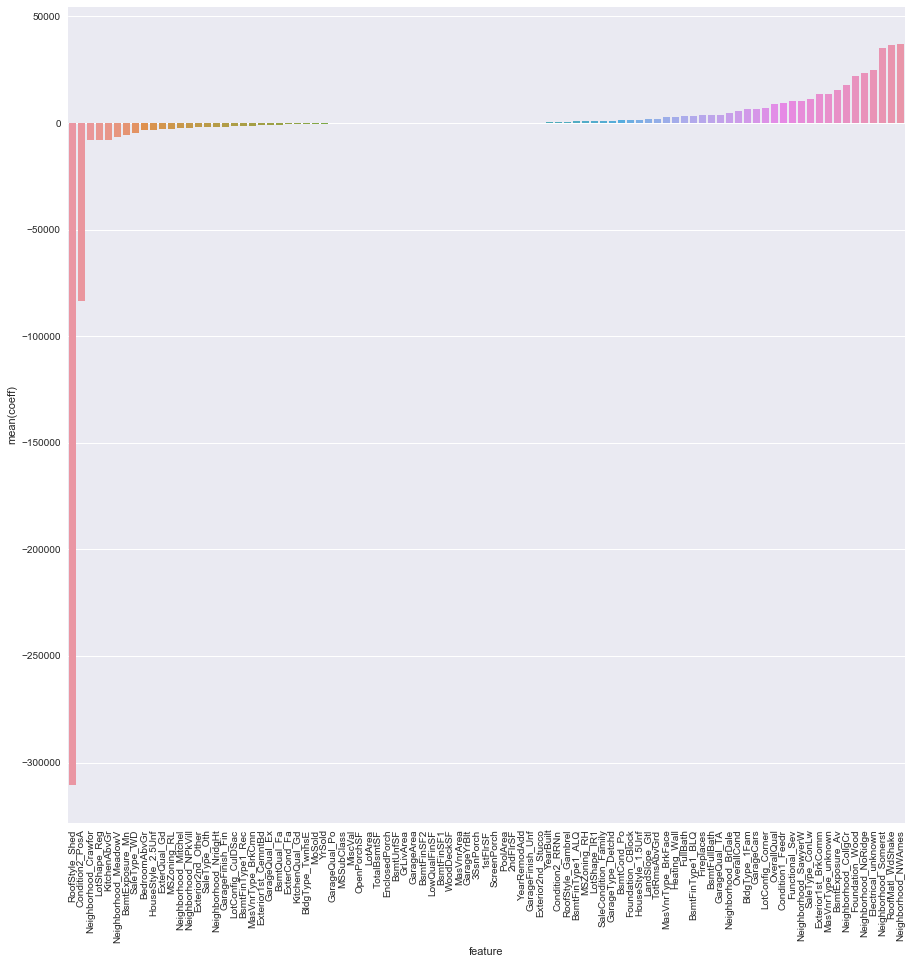

In [27]:
plt.figure(figsize=(15, 15))
temp_df = pd.DataFrame(list(zip(lassocv.coef_, df.columns)), columns=["coeff", "feature"])
eps = 1e-4
ax =sns.barplot(x='feature', y='coeff', data=temp_df[np.abs(temp_df['coeff']) > eps].sort_values(by='coeff'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 10})
plt.show()

In [28]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
lassocv = LassoCV(alphas=[150], random_state=42, cv=5)
np.mean(cross_val_score(lassocv, X, Y, cv=kfold, n_jobs=3, scoring='neg_mean_squared_error'))

-1123984352.5471156

## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.33)

In [30]:
print(X_train.shape)
print(X_test.shape)

(978, 280)
(482, 280)


Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

In [31]:
lassocv = LassoCV(alphas=[141], random_state=42, cv=5)
lassocv.fit(X_train, Y_train)

LassoCV(alphas=[141], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

In [32]:
Y_pred = lassocv.predict(X_test)

Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

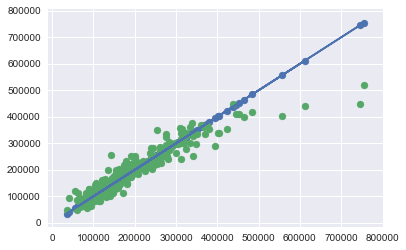

In [33]:
plt.plot(Y_test, Y_test)
plt.scatter(Y_test, Y_test)
plt.scatter(Y_test, Y_pred)

## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

In [34]:
X = X[important_features]

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lassocv = LassoCV(alphas=[1], random_state=42, cv=5)
np.mean(cross_val_score(lassocv, X, Y, cv=kf, scoring='neg_mean_squared_error'))

-1616870220.3113925

Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.